In [1]:
import networkx as nx
import matplotlib.pylab as plt
%matplotlib inline

# from rpy2.robjects.packages import importr
# igraph = importr('igraph')
# import pandas as pd
# from rpy2.robjects import r, pandas2ri
# a = pandas2ri.py2ri(nx.to_pandas_adjacency(nxG))

import os
import numpy as np
import rpy2.robjects as robjects
import pandas as pd

In [2]:
def community(nxG, algorithm, fig_name = "G"):
    """
    In:
        nxG: grafo de networkx.
        algorithm: string, entre las siguientes opciones: 
            fast_greedy
            edge_betweenness
            louvain
            infomap
        fig_name: nombre de la figura que se genera al clsuterizar. Le agrega automaticamente el nombre del algoritmo usado y el nombre del grafo si lo tuviere
    Out:
        labels: numpy array con la pertenencia de cada nodo al cluster.
    
    """
    gml_file_name = "G.gml"
    fig_name += "_"+nxG.name+"_"+algorithm+".svg"
    nx.write_gml(nxG, gml_file_name)
    
    igG = robjects.r('''
        f <- function(file, algorithm, fig_name, v_names){
            require("igraph")     
            
            G <- read.graph(file, "gml")
            V(G)$name <- as.character(unlist(v_names))
            #format = c("edgelist", "pajek", "ncol", "lgl", "graphml","dimacs", "graphdb", "gml", "dl"), ...)
            
            if(algorithm == "fast_greedy"){
                c <- fastgreedy.community(G)
                #c <- cluster_fast_greedy(G, merges = TRUE, modularity = TRUE, membership = TRUE)
            }
            
            if(algorithm == "edge_betweenness"){
                c <- edge.betweenness.community(G)
                #c <- cluster_edge_betweenness(G,directed = FALSE,edge.betweenness = TRUE)
            }
            
            if(algorithm == "louvain"){
                c <- multilevel.community(G)
                #c <- cluster_louvain(G)
            }
            
            if(algorithm == "infomap"){
                #c <- cluster_infomap(G)
                c <- infomap.community(G)
            }
            
            svg(fig_name)
            plot(c, G)
            dev.off()
            
            return(list(membership(c), as.character(V(G)$name)))
        }
    ''')
    
    labels = igG(gml_file_name, algorithm, fig_name, list(dict(nxG.nodes(data=True)).keys()))
    os.remove(gml_file_name)
    return {name: int(label) for name, label in zip(labels[1],labels[0])}



In [9]:
G = nx.read_gml("dolphins.gml")
labels_infomap = community(G, "infomap")
labels_fast_greedy = community(G, "fast_greedy")
labels_edge_betweenness = community(G, "edge_betweenness")
labels_louvain = community(G, "louvain")


In [36]:
df = pd.DataFrame()
df['Nombre'] = labels_louvain.keys()
df['Comunidad'] = labels_louvain.values()

df.to_csv('./comparacion/labels_louvain.txt',sep='\t')

In [11]:
nombres = ['infomap','fast_greedy','edge_betweenness','louvain']

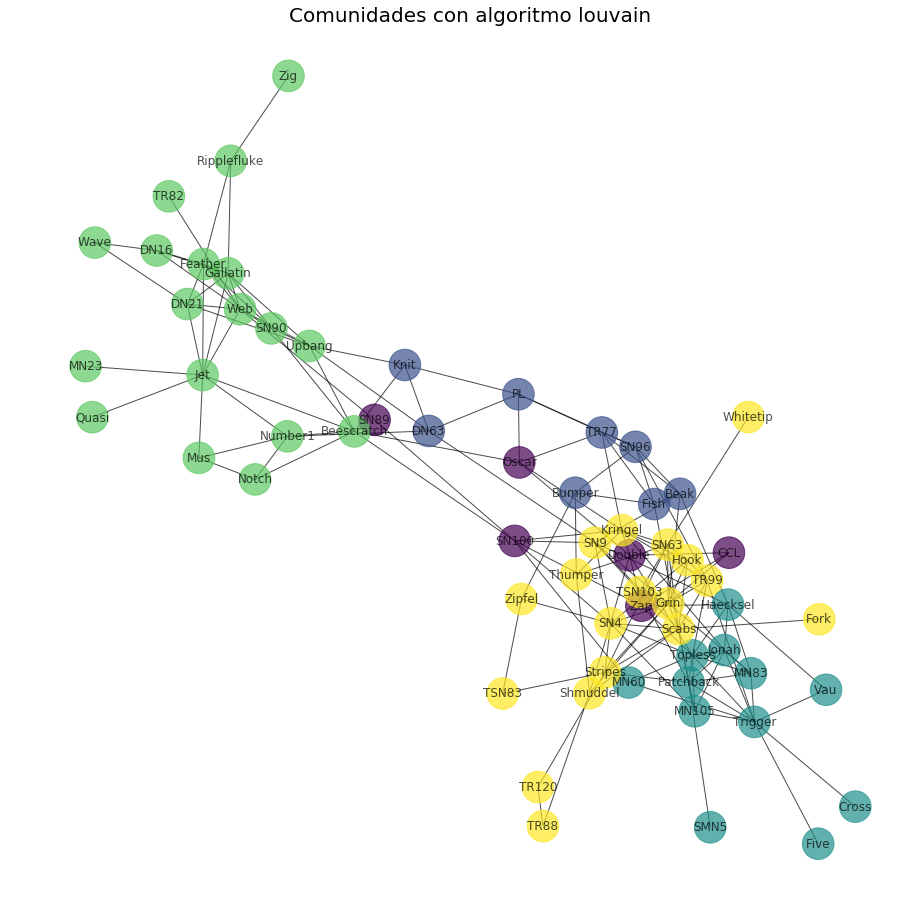

In [47]:
for name,label in labels_louvain.items():
    G.nodes()[name]["color"] = label

fig=plt.figure(figsize=(12, 12))

nx.draw(G, node_color=list(nx.get_node_attributes(G, "color").values()),alpha=0.7,with_labels=True,node_size=1000)

#Etiquetas
plt.title('Comunidades con algoritmo louvain',fontsize=20)
plt.axis('off')
#plt.savefig('./comparacion/louvain.png',dpi=150)
plt.show()

In [25]:
# Cantidad de comunidades
nro_coms = np.zeros(4)

nro_coms[0] = len(np.unique(list(labels_infomap.values())))
nro_coms[1] = len(np.unique(list(labels_fast_greedy.values())))
nro_coms[2] = len(np.unique(list(labels_edge_betweenness.values())))
nro_coms[3] = len(np.unique(list(labels_louvain.values())))

nro_coms

array([6., 5., 5., 5.])

In [53]:
#------------------------------------------------------------------------------------------------------
#Caracterización de Modularidad y Silhouette
#------------------------------------------------------------------------------------------------------
#Modularidad Total:
#-------------------------------------------------------------

comunidades = list(labels_louvain.values())
delfines = list(labels_louvain.keys())

#Matriz de Adyacencias Aij:
A = np.array(nx.to_numpy_matrix(G,nodelist=delfines))
N=G.number_of_nodes()
m=G.number_of_edges()
grado = dict(G.degree())

#Matriz de variable categorica comunidad: Cij=delta(ci,cj)
C=np.zeros(np.shape(A))
for i,com_i in enumerate(comunidades):
    for j,com_j in enumerate(comunidades):
        if (com_i==com_j):
            C[i,j]=1
            
#Calculo de la modularidad
#Q/Qmax=(S1-S2)*(1/2m)
#S1=Suma en nodos (Aij*Cij)
#S2=Suma en nodos(kikj*Cij/2m)
S1=0
S2=0
for ni, delfin_i in enumerate(delfines):
    for nj, delfin_j in enumerate(delfines):  
        S1=S1+A[ni,nj]*C[ni,nj]
        S2=S2+grado[delfin_i]*grado[delfin_j]*C[ni,nj]
S2=S2/(2*m)

mod[3]=(S1-S2)/(2*m)



In [64]:
#------------------------------------------------------------------------------------------------------
#Silhouette:
#-------------------------------------------------------------
#Nota importante: list(part.keys())[i] representa el delfin en el lugar i-ésimo y comunidades es la lista de las comunidades de cada delfin
#Y que list(part.values())[i] representa la comunidad a la q pertenece

comunidades = list(labels_infomap.values())
delfines = list(labels_infomap.keys())

#Calculo a[i]
a=[] #contendra para cada nodo en delfines la distancia promedio a nodos de su misma comunidad
for i,delfin_i in enumerate(delfines):
    distancias=[]
    for j, delfin_j in enumerate(delfines):
        if comunidades[i]==comunidades[j]:
               distancias.append(nx.shortest_path_length(G,delfin_i,delfin_j))
    promedio=np.mean(distancias)
    a.append(promedio)


#Calculo b[i]
b=[] #contendria para cada delfin la distancia promedio a nodos de otras comunidades, devuelvo el promedio minimo
ls=np.unique(comunidades)
for i,delfin_i in enumerate(delfines):
    distancias_prom=[] #es la lista q tiene mis distancias minimas 
    for c in ls: #recorro las comunidades
        distancias=[] #armo una lista que me indique las distancias por comunidad
        for j, delfin_j in enumerate(delfines): #recorro nuevamente para comparar
            if (comunidades[i]!=comunidades[j] and comunidades[j]==c): #Busco de forma ordenada los delfines
                #distancias.append((c, com_i, com_j,len(nx.shortest_path(G,list(part.keys())[i],list(part.keys())[j]))-1)) #esto es para ver si funcionaba bien
                distancias.append(nx.shortest_path_length(G,delfin_i,delfin_j))
        if len(distancias)!=0: #hay algunos c para los cuales la lista queda vacia
            distancias_prom.append(np.mean(distancias))
        
    b.append(min(distancias_prom))

#Calculo Silhouette    
S=[]
for i,com_i in enumerate(comunidades):
    s=(b[i]-a[i])/(max(b[i],a[i]))
    S.append(s)



silhouette[0] = np.mean(S)

df = pd.DataFrame()
df['Nombre'] = labels_infomap.keys()
df['Silhouette'] = S

df.to_csv('./comparacion/silhouette_infomap.txt',sep='\t')

silhouette

array([ 0.03832616, -0.06595401, -0.00217759,  0.03644232])

In [66]:
df = pd.DataFrame()
df['Metodo'] = nombres
df['Silhouette'] = silhouette
df['Modularidad'] = mod
df['Nro coms'] = nro_coms

df.to_csv('./comparacion/resultados_metodos.txt',sep='\t')

df

,Metodo,Silhouette,Modularidad,Nro coms
0,infomap,0.038326,0.124461,6.0
1,fast_greedy,-0.065954,0.136684,5.0
2,edge_betweenness,-0.002178,0.132155,5.0
3,louvain,0.036442,0.140244,5.0


## Falta modularidad por comunidad?

